# Transfer learning - Fixed Feature Extractor


## Creating and using a Fixed Feature Extractor


In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = datasets.CIFAR10(root='data/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='data/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


# The VGG 16

Now, we need to let the model learn by scanning the images and optimize the weights at each iteration. However, we only want to train the classifier layer but not the feature extraction layer, and this is called transfer learning. The part on the left of the image below will not be changed (we say, weights are freezed), but we change/optimize the part on the right side.

<img alt="Available loss functions" src="images/transfer_learning_vgg.png" width="60%"/>



In [5]:
model = models.vgg16(pretrained = True)

In [6]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [14]:
# Freezing all parameters (means, setting all parameters to static - don't learn during training)
for param in model.parameters(): #model.parameters is a dictionnary, model.parameters() is a generator
    param.requires_grad = False

In [15]:
model.classifier[-1] = nn.Sequential(
    nn.Linear(in_features= 4096, out_features = 10), #10 classes
    nn.LogSoftmax(dim = 1)
) #This is the only layer that will be optimized

In [16]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [ ]:
# Have a look on which parameters are freezed and which are not
for param in model.parameters():
    print(param.requires_grad)


# We need to specify a loss function.
Here is a list of the available loss functions in pytorch:

<img alt="Available loss functions" src="images/loss.png" width="60%"/>

For our classification problem, we can use either the NLLoss or the Softmax. 

<img alt="Available loss functions" src="images/nlllos_vs_logsoftmax.png" width="60%"/>

However, the network should be programmed differently in each case:
- If we decided tp use Negative Log Likelihood Loss (NLLLos), then the log of the softmax is not computed explicitely. Therefore, we need to add the LogSoftMax as shown in the upper part of the picture.
- If we decided to use CrossEntropyLoss (which combines both NLLoss and LogSoftMax), then there is no need to add a LogSoftMax Layer after the last linear layer in the classifier as shown in the lower part of the picture below.
<img alt="Available loss functions" src="images/nlllos_vs_logsoftmax_layers.png" width="60%"/>


The CrossEntropy function combines NLLoss (Negativa Log Likelihood) and LogSoftMax in the same function:
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html


In [12]:
criterion = nn.NLLLoss()

In [17]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

## Training the Fixed Feature Extractor

GPUs are not replacements for CPUs, but rather they assist them in doing computationally expensive calculations such as matrix multiplication (which is all what is about during the training and inference process). We need to move the model and inputs/outputs to a CUDA device when we train the model.

<img alt="CPU to GPU" src="images/moving_cpu_gpu.png" width="60%"/>


In [18]:
from torch.optim import Adam

model = model.to(device) #Move the model to the GPU device
optimizer = Adam(model.parameters()) #Define the optimizer (the mechanism used to update the wiehgts, this is a variant of gradient descent)

The training happens in steps as shown below. The weight are updated at each epoch

<img alt="Available loss functions" src="images/training_steps_withOptimiser.png" width="60%"/>


To see the correpondance of the training steps and how they are reflect in code, check the image below:

<img alt="Available loss functions" src="images/training_steps_withCode.png" width="60%"/>


In [ ]:
#Should take between 5 and 10 minutes

num_epochs = 1
batch_loss = 0
cum_epoch_loss = 0

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
    
  print(f'Training loss : {batch_loss/len(trainloader)}')  
    

## Evaluating thet network and viewing images

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [21]:
#List of classes (already known from the CIFAR website)
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Inference normally runs on CPU (live inference for example)
model.to('cpu')

#To remove the effect of dropout layers. If there is no dropouts, then this is not necessay. 
model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


tensor([[4.7809e-04, 7.2123e-03, 2.3763e-03, 7.7030e-01, 1.6886e-04, 5.8495e-02,
         1.4887e-01, 4.2561e-03, 7.0948e-03, 7.5666e-04],
        [9.9723e-03, 2.8952e-01, 1.3994e-05, 5.4116e-05, 8.8514e-07, 8.3885e-06,
         1.4064e-05, 2.2977e-06, 6.9663e-01, 3.7821e-03],
        [2.2259e-04, 3.1437e-03, 7.6446e-07, 9.7628e-07, 2.4110e-07, 5.2100e-08,
         2.4718e-08, 4.7813e-07, 9.9659e-01, 3.8708e-05],
        [3.8470e-01, 1.7066e-03, 3.8736e-02, 1.4032e-01, 1.4260e-03, 3.2126e-03,
         1.0739e-02, 1.8199e-03, 4.0985e-01, 7.4824e-03],
        [5.0604e-08, 2.5939e-07, 2.7495e-03, 1.9522e-03, 3.7822e-04, 8.4564e-06,
         9.9491e-01, 9.9232e-08, 3.0760e-07, 3.9604e-07],
        [1.2301e-05, 5.1620e-06, 2.6324e-04, 2.0338e-01, 1.8119e-02, 6.8181e-02,
         7.0966e-01, 3.3371e-04, 7.6511e-07, 4.9378e-05],
        [5.6620e-06, 9.9206e-01, 5.1535e-07, 3.4131e-05, 3.0327e-08, 3.7000e-05,
         3.7860e-06, 1.0054e-05, 7.8578e-06, 7.8451e-03],
        [1.8658e-02, 5.8955

In [24]:
sum(output[0]) #Sum of all probabilities is equal to 1

tensor(1.)

In [25]:
#What is the class that got the highest probability?
pred = torch.argmax(output,1)  
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
pred #Will output 64 predictions (for the whole batch)

tensor([3, 8, 8, 8, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 8, 3, 8, 8, 3, 3, 3, 3, 7, 3, 6, 3])

## Viewing images & normalization - Under the hood

In [27]:
images.size()

torch.Size([64, 3, 224, 224])

In [28]:
images[0].size()

torch.Size([3, 224, 224])

In [41]:
help(plt.imshow) #Look at the supported array shape and compare it to the images[0] shape

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display data as an image; i.e. on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. Note: For actually displaying
    a grayscale image set up the color mapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The values are mapped to
          colors using normalization and a colormap. See parameters *norm*,
          *cmap*, *vmin*, *vmax*.
        - (M, N, 3): an image with RGB values (0-1 float or 

In [29]:
#To use matplotlib for visualizing images, we need to change the shape of the tensor/image
im_np = np.transpose(images[0], (1, 0, 2)) #(0,1,2) will keep axis as is. (1,0,2) will swap axis 0 and 1
im_np.shape

torch.Size([224, 3, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


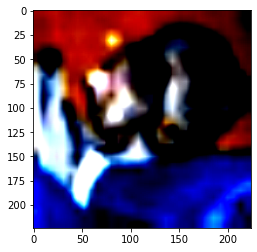

In [30]:
# What we actually need is to transpose from [3, 244, 244] to [244, 244, 3] which means replacing the 0th dim with the first, the second with the third
#and the third with the 0th (0,1,2) ==> (1, 2, 0). 
im_np = np.transpose(images[0], (1,2,0) )
im_np.shape
plt.imshow(im_np)

In [31]:
#Print a sample of the image content
print(im_np[0][1])
'''
Values of the image are in the negative (due to normalization). Imshow automatically clip them 
to [0,1] if it detects and RGB image but we can also clip them and apply it after the transpose
directly.
'''
#help(np.clip)

tensor([ 0.5878, -0.0749, -0.9504])


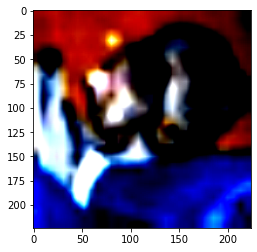

In [32]:
im_np = np.clip(np.transpose(images[0], (1,2,0) ), 0, 1)
im_np.shape
plt.imshow(im_np)

In [33]:

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]



cat


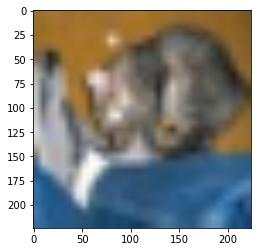

In [34]:
test_image_id=0 #Change this to experiment with different images
show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))

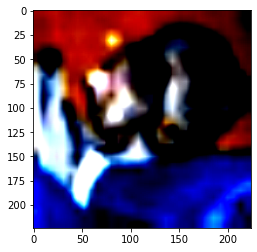

In [35]:
#Coompare the normalized and denormalized images!
plt.imshow(im_np)

## Accuracy of the model

In [36]:
model.eval() #remove the effect of the dropout layer
with torch.no_grad():
    num_correct = 0 #to store the prediction where pred = ground_truth
    total = 0


    for batch, (images, labels) in enumerate(testloader,1):
        
        logps = model(images)
        output = torch.exp(logps) #log values ==> transform to exp to get the probabilities
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(testloader)})')
        
        if batch == 5:
          break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/157)
Batch (2/157)
Batch (3/157)
Batch (4/157)
Batch (5/157)
Accuracy of the model on 320 test images: 79.375% 


# Saving the model

In [37]:
# Can
torch.save(model.state_dict(), "data/model_vgg16.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Loading the model

In [39]:
model = models.vgg16()
model.classifier[-1] = nn.Sequential(
    nn.Linear(in_features= 4096, out_features = 10), #10 classes
    nn.LogSoftmax(dim = 1)
)
model.load_state_dict(torch.load("data/model_vgg16.pth"))

<All keys matched successfully>

In [53]:
'''
trainset = datasets.CIFAR10(root='data/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='data/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
'''

model.eval()
x, y = next(iter(testloader))
x.size()

torch.Size([64, 3, 224, 224])

In [55]:
with torch.no_grad():
    pred = model(x)
    predicted, actual = pred, y

In [63]:
torch.argmax(predicted, 1)

tensor([3, 8, 8, 8, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 8, 3, 8, 8, 3, 3, 3, 3, 7, 3, 6, 3])

In [57]:
actual #Compare actual and predicted

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])